In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d_exact, ising3d_monte_carlo as ising3d_mc
from TNModels import AKLT3D
from scipy.interpolate import interp1d,PchipInterpolator
from glob import glob
import numpy as np
import os
from tqdm.auto import tqdm

In [28]:
# task_name='AKLT3D_X10_scan_grid'
# critical_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}
# clim=[0,3]

task_name='AKLTDiamond_X10_scan_grid'
critical_params={'a1':np.sqrt(6/4),'a2':np.sqrt(6/1)}
clim=[0,4]

# task_name='AKLT2D_X24_scan_grid'
# critical_params={'a1':np.sqrt(6/4),'a2':np.sqrt(6/1)}
# clim=[0,2]

  0%|          | 0/121 [00:00<?, ?it/s]

loaded 121 files
saved to ./data_output/AKLTDiamond_X10_scan_grid/AKLTDiamond_X10_scan_grid_observables.csv


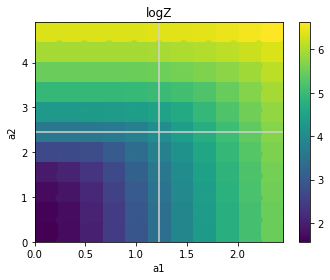

saved to ./data_output/AKLTDiamond_X10_scan_grid/AKLTDiamond_X10_scan_grid_logZ.png


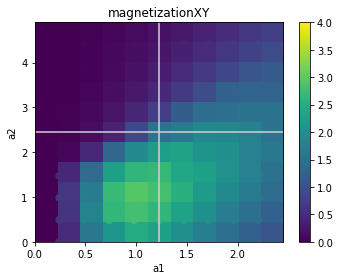

saved to ./data_output/AKLTDiamond_X10_scan_grid/AKLTDiamond_X10_scan_grid_magnetizationXY.png


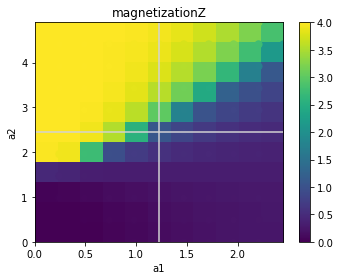

saved to ./data_output/AKLTDiamond_X10_scan_grid/AKLTDiamond_X10_scan_grid_magnetizationZ.png


In [31]:
# %matplotlib widget
%matplotlib inline

def load_df(filenames):
    filenames=sorted(filenames,key=lambda x:os.path.getmtime(x))
    dfs=[]
    for filename in tqdm(filenames):
        df=pd.read_csv(filename)
        dfs.append(df)
        # print(filename)
    print('loaded {} files'.format(len(dfs)))
    df=pd.concat(dfs)
    df['magnetizationXY']=(df['magnetizationX']**2+df['magnetizationY']**2)**.5
    df['magnetizationXYZ']=(df['magnetizationX']**2+df['magnetizationY']**2+df['magnetizationZ']**2)**.5
    return df
def image_plot_2D(df,obs_name,clim=None,filename=None):
    fig=plt.figure(figsize=(5,4))
    plt.axhline(critical_params['a2'],c='lightgrey')
    plt.axvline(critical_params['a1'],c='lightgrey')
    df=df.sort_values(by=['a1','a2'])
    a1s=np.unique(df['a1'])
    a2s=np.unique(df['a2'])
    obs=df[obs_name].values.reshape(len(a2s),len(a1s)).T
    plt.imshow(obs,origin='lower',extent=[a1s[0],a1s[-1],a2s[0],a2s[-1]],aspect='auto',cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    plt.scatter(df['a1'],df['a2'],c=df[obs_name],s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    plt.xlabel('a1');plt.ylabel('a2');plt.title(obs_name)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')
def surface_plot_2D(df,obs_name,clim=None,filename=None):
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111,projection='3d')
    df=df.sort_values(by=['a1','a2'])
    p=ax.plot_trisurf(df['a1'],df['a2'],df[obs_name],cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    ax.set_xlabel('a1');ax.set_ylabel('a2');ax.set_zlabel(obs_name)
    fig.colorbar(p)
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')

def grid_plot_3D(df,obs_name,clim=None,filename=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    # draw a 3d cross at critical point
    p=ax.scatter(df['a1'],df['a2'],df['a3'],c=df[obs_name],cmap='viridis',s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    ax.set_xlabel('a1');ax.set_ylabel('a2');ax.set_zlabel('a3');ax.set_title(obs_name)
    fig.colorbar(p)
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')
def surface_plot_section(df,obs_name,slice_param_name,slice_value,clim=None,filename=None):
    df=df[np.isclose(df[slice_param_name],slice_value)]
    other_param_names=[x for x in ['a1','a2','a3'] if x!=slice_param_name]
    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111,projection='3d')
    df=df.sort_values(by=other_param_names)
    p=ax.plot_trisurf(df[other_param_names[0]],df[other_param_names[1]],df[obs_name],cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    # p=ax.scatter(df[other_param_names[0]],df[other_param_names[1]],df[obs_name],c=df[obs_name],cmap='viridis',s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    ax.set_xlabel(other_param_names[0]);ax.set_ylabel(other_param_names[1]);ax.set_zlabel(obs_name)
    ax.set_title("{obs_name} {slice_param_name}={slice_value}".format(obs_name=obs_name,slice_param_name=slice_param_name,slice_value=slice_value))
    fig.colorbar(p)
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')

def image_plot_section(df,obs_name,slice_param_name,slice_value,clim=None,filename=None):
    df=df[np.isclose(df[slice_param_name],slice_value)]
    other_param_names=[x for x in ['a1','a2','a3'] if x!=slice_param_name]
    fig=plt.figure(figsize=(5,4))
    plt.axhline(critical_params[other_param_names[1]],c='lightgrey')
    plt.axvline(critical_params[other_param_names[0]],c='lightgrey')
    df=df.sort_values(by=other_param_names)
    a1s=np.unique(df[other_param_names[0]])
    a2s=np.unique(df[other_param_names[1]])
    obs=df[obs_name].values.reshape(len(a2s),len(a1s)).T
    plt.imshow(obs,origin='lower',extent=[a1s[0],a1s[-1],a2s[0],a2s[-1]],aspect='auto',cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    plt.scatter(df[other_param_names[0]],df[other_param_names[1]],c=df[obs_name],s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    plt.xlabel(other_param_names[0]);plt.ylabel(other_param_names[1]);plt.title(obs_name)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')




df_all=load_df(glob(f'./data/{task_name}/*/observables.csv'))
df=df_all[df_all['iLayer']==60]
os.makedirs(f'./data_output/{task_name}/',exist_ok=True)
df.to_csv(f'./data_output/{task_name}/{task_name}_observables.csv',index=False)
print(f'saved to ./data_output/{task_name}/{task_name}_observables.csv')


if len(critical_params)==3:
    # plot_section=surface_plot_section
    plot_section=image_plot_section
    plot_section(df,'logZ','a1',np.sqrt(20/15),filename=f'./data_output/{task_name}/{task_name}_logZ_a1.png')
    plot_section(df,'magnetizationXY','a1',np.sqrt(20/15),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationXY_a1.png')
    plot_section(df,'magnetizationZ','a1',np.sqrt(20/15),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationZ_a1.png')

    plot_section(df,'logZ','a2',np.sqrt(20/6),filename=f'./data_output/{task_name}/{task_name}_logZ_a2.png')
    plot_section(df,'magnetizationXY','a2',np.sqrt(20/6),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationXY_a2.png')
    plot_section(df,'magnetizationZ','a2',np.sqrt(20/6),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationZ_a2.png')

    plot_section(df,'logZ','a3',np.sqrt(20/1),filename=f'./data_output/{task_name}/{task_name}_logZ_a3.png')
    plot_section(df,'magnetizationXY','a3',np.sqrt(20/1),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationXY_a3.png')
    plot_section(df,'magnetizationZ','a3',np.sqrt(20/1),clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationZ_a3.png')
    
    grid_plot_3D(df,'logZ',filename=f'./data_output/{task_name}/{task_name}_logZ.png')
    grid_plot_3D(df,'magnetizationXY',clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationXY.png')
    grid_plot_3D(df,'magnetizationZ',clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationZ.png')
elif len(critical_params)==2:
    plot_2D=image_plot_2D
    # plot_2D=surface_plot_2D
    plot_2D(df,'logZ',filename=f'./data_output/{task_name}/{task_name}_logZ.png')
    plot_2D(df,'magnetizationXY',clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationXY.png')
    plot_2D(df,'magnetizationZ',clim=clim,filename=f'./data_output/{task_name}/{task_name}_magnetizationZ.png')